<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [13]:
# system library
import os
import sys
import json
import pickle
import isoweek
import datetime
import calendar
from tqdm.notebook import tqdm
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve

# svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

In [2]:
ts_column_name = 'frequency'

<h6> Datasets loading </h6>

In [3]:
filename = "TS_album_type_" + ts_column_name + ".csv"
df = pd.read_csv('../../data/fma_metadata/' + filename, index_col=0)
print(df.shape)

(70224, 2)


<h6> Dataset statistics </h6>

In [4]:
df['Studio_Recording_' + ts_column_name].describe()

count    70224.000000
mean         1.242681
std          4.604978
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        193.000000
Name: Studio_Recording_frequency, dtype: float64

In [5]:
df['Live_Recording_' + ts_column_name].describe()

count    70224.000000
mean         0.137332
std          1.161236
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        104.000000
Name: Live_Recording_frequency, dtype: float64

<h2>Visualize Raw Data</h2>

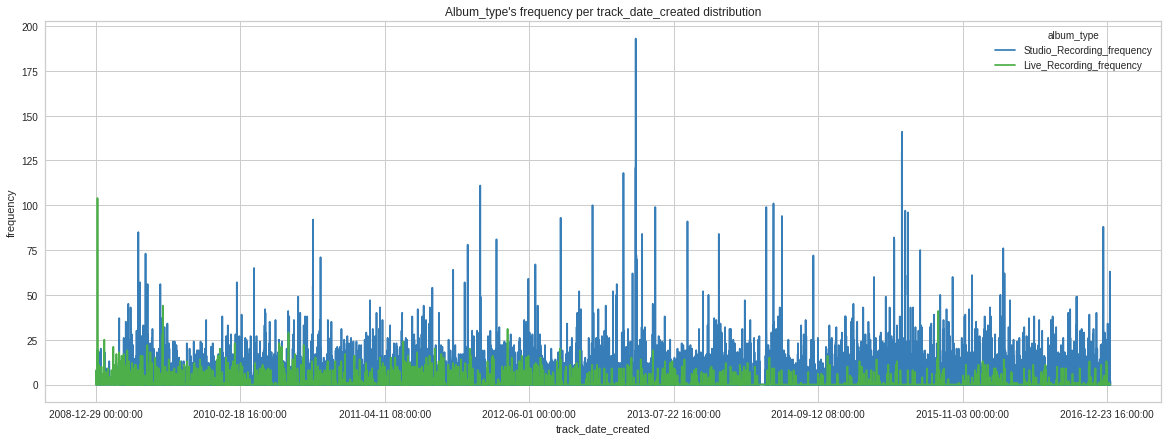

In [6]:
df.plot(figsize=(20,7))
plt.xlabel('track_date_created')
plt.ylabel(ts_column_name)
plt.legend(title='album_type')
plt.title("Album_type's %s per track_date_created distribution" % ts_column_name)
plt.show()

<h6>Compute Matrix Profiles</h6>

Here we compute Matrix Profiles over varying window sizes:

- 12 hours (1/2 of a day);
- 24 hours (1 day);
- 168 hours (7 days);
- 720 hours (30 days);
- 2190 hours (90 days);
- 4380 hours (180 days);
- 8760 hours (360 days).

In [7]:
from matrixprofile import *

In [16]:
def get_stomp_matrix_profile(ts, w, name):
    mp, mpi = matrixProfile.stomp(ts, w)
    plt.plot(mp)
    plt.title(str(name) + "'s Matrix Profile" + " - w = " + str(w))
    plt.show()
    return mp, mpi

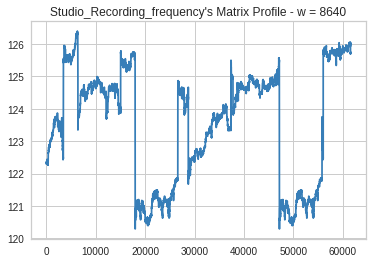

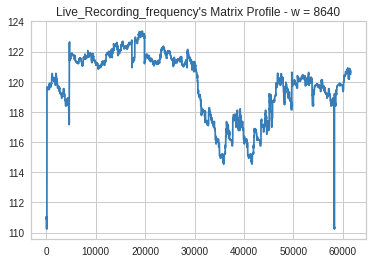

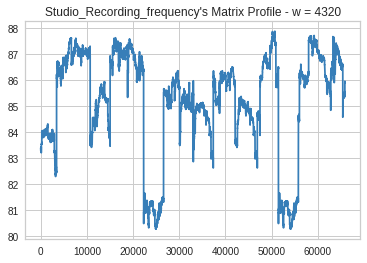

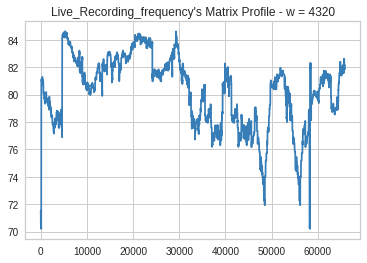

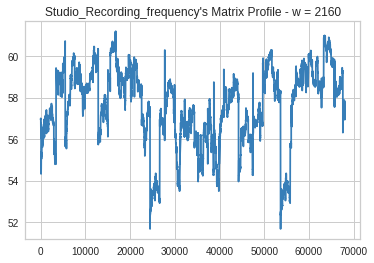

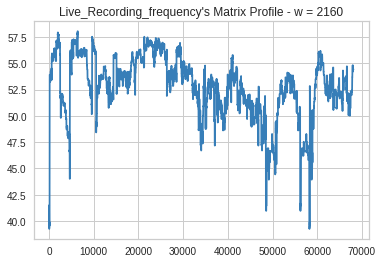

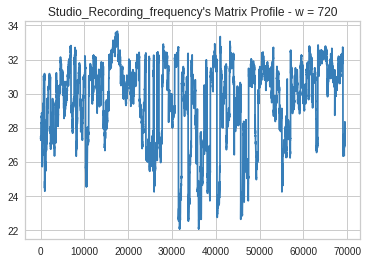

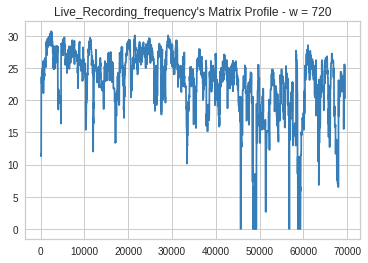

/home/alexandra/anaconda3/lib/python3.8/site-packages/matrixprofile/utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
/home/alexandra/anaconda3/lib/python3.8/site-packages/matrixprofile/utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
/home/alexandra/anaconda3/lib/python3.8/site-packages/matrixprofile/utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
/home/alexandra/anaconda3/lib/python3.8/site-packages/matrixprofile/utils.py:200: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))


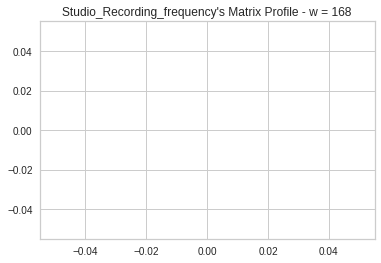

/home/alexandra/anaconda3/lib/python3.8/site-packages/matrixprofile/utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
/home/alexandra/anaconda3/lib/python3.8/site-packages/matrixprofile/utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
/home/alexandra/anaconda3/lib/python3.8/site-packages/matrixprofile/utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
/home/alexandra/anaconda3/lib/python3.8/site-packages/matrixprofile/utils.py:200: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))


KeyboardInterrupt: 

In [24]:
windows = [
    ('1 Year', 30 * 24 * 12),
    ('180 Days', 30 * 24 * 6),
    ('90 Days', 30 * 24 * 3),
    ('30 Days', 30 * 24)
    ]
"""('7 Days', 7 * 24),
('24 Hours', 24),
('12 Hours', 12)
]"""

studio_profiles = {}
live_profiles = {}
for label, window_size in tqdm(windows):
    studio_key = 'Studio_Recording_' + ts_column_name
    live_key = 'Live_Recording_' + ts_column_name
    
    studio_ts = df[studio_key].values
    live_ts = df[live_key].values
    
    studio_mp, studio_mpi = get_stomp_matrix_profile(studio_ts, window_size, studio_key)
    live_mp, live_mpi = get_stomp_matrix_profile(live_ts, window_size, live_key)

    key = '%s profile' % str(label)
    studio_profiles[key] = studio_mp, studio_mpi 
    live_profiles[key] =  live_mp, live_mpi

<h2> Motif Discovery </h2>

In [34]:
def plot_motifs(ts, mo, mod, w, name):
    plt.plot(ts)
    colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
    for m, d, c in zip(mo, mod, colors):
        for i in m:
            m_shape = ts[i:i+w]
            plt.plot(range(i,i+w), m_shape, color=c, lw=3)

    plt.title(str(name) + "'s Matrix Profile" + " - w = " + str(w))
    plt.show()

In [35]:
studio_motifs = {}
live_motifs = {}
for label, window_size in tqdm(windows):
    studio_key = 'Studio_Recording_' + ts_column_name
    live_key = 'Live_Recording_' + ts_column_name
    
    studio_ts = df[studio_key].values
    live_ts = df[live_key].values
    
    key = '%s profile' % str(label)
    studio_mp, studio_mpi  = studio_profiles[key][0], studio_profiles[key][1]
    live_mp, live_mpi = live_profiles[key][0], live_profiles[key][1]
    
    studio_mo, studio_mod  = motifs.motifs(studio_ts, (studio_mp, studio_mpi), max_motifs=5)
    live_mo, live_mod  = motifs.motifs(live_ts, (live_mp, live_mpi), max_motifs=5)

    key = '%s motifs' % str(label)
    studio_motifs[key] = studio_mo, studio_mod 
    live_motifs[key] =  live_mo, live_mod

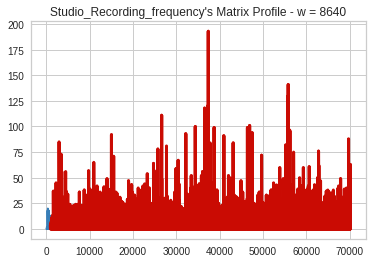

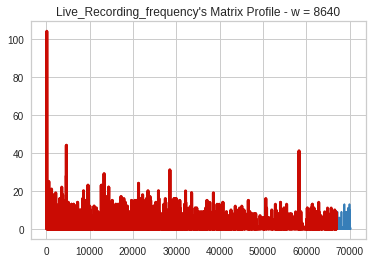

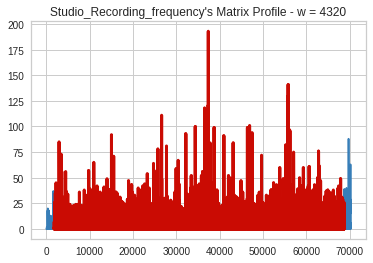

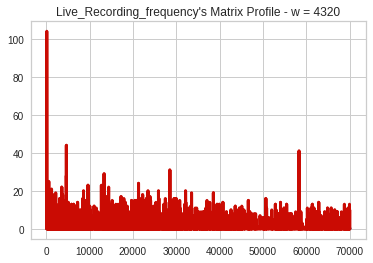

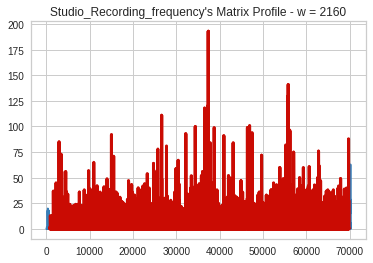

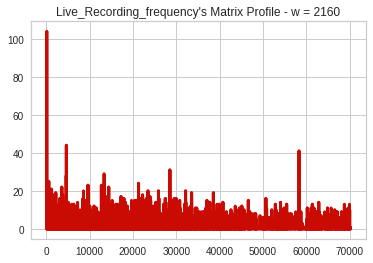

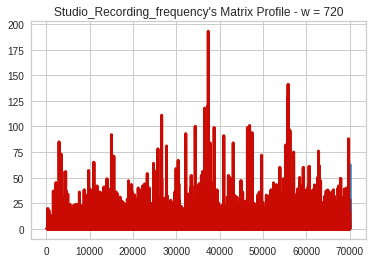

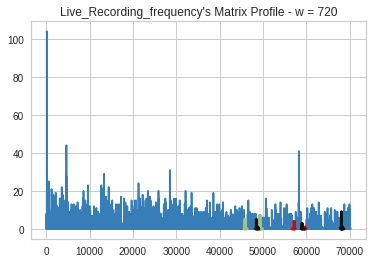

In [36]:
# plot motifs
for label, window_size in tqdm(windows):
    studio_key = 'Studio_Recording_' + ts_column_name
    live_key = 'Live_Recording_' + ts_column_name
    
    studio_ts = df[studio_key].values
    live_ts = df[live_key].values
    
    key = '%s motifs' % str(label)
    studio_mo, studio_mod  = studio_motifs[key][0], studio_motifs[key][1]
    live_mo, live_mod = live_motifs[key][0], live_motifs[key][1]
    
    plot_motifs(studio_ts, studio_mo, studio_mod, window_size, studio_key)
    plot_motifs(live_ts, live_mo, live_mod, window_size, live_key)

<h2> Anomaly Discovery </h2>

In [38]:
from matrixprofile.discords import discords

In [39]:
def plot_anomalies(ts, mo, anoms, w, name):
    plt.plot(ts)
    colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
    for a, c in zip(anoms, colors):
        a_shape = ts[a:a+w]
        plt.plot(range(a, a+w), a_shape, color=c, lw=3)
    
    plt.title(str(name) + "'s Matrix Profile" + " - w = " + str(w))
    plt.show()

In [40]:
studio_anomalies = {}
live_anomalies = {}
for label, window_size in tqdm(windows):
    studio_key = 'Studio_Recording_' + ts_column_name
    live_key = 'Live_Recording_' + ts_column_name
    
    studio_ts = df[studio_key].values
    live_ts = df[live_key].values
    
    key = '%s profile' % str(label)
    studio_mp, studio_mpi  = studio_profiles[key][0], studio_profiles[key][1]
    live_mp, live_mpi = live_profiles[key][0], live_profiles[key][1]
    
    studio_anoms = discords(studio_mp, ex_zone=3, k=5)
    live_anoms = discords(live_mp, ex_zone=3, k=5)

    key = '%s anomalies' % str(label)
    studio_anomalies[key] = studio_anoms
    live_anomalies[key] =  live_anoms

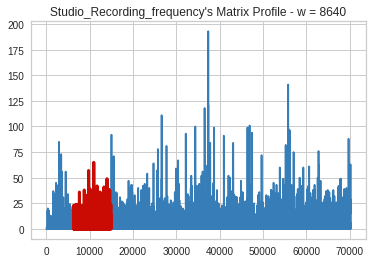

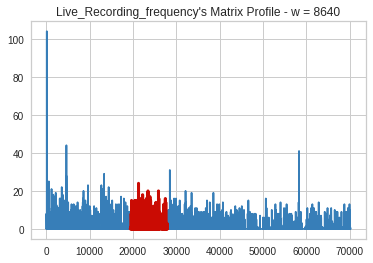

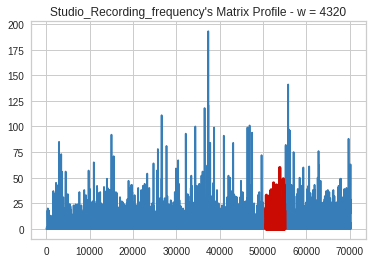

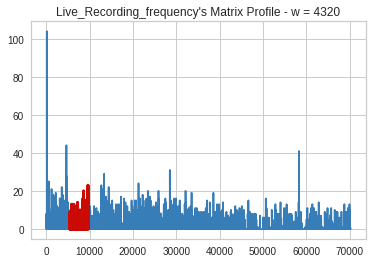

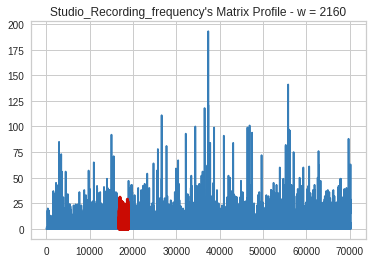

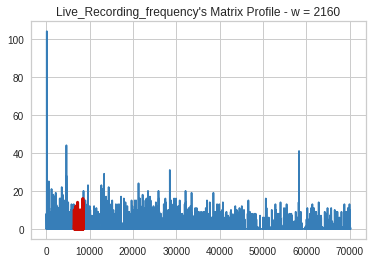

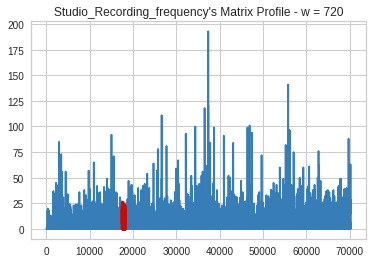

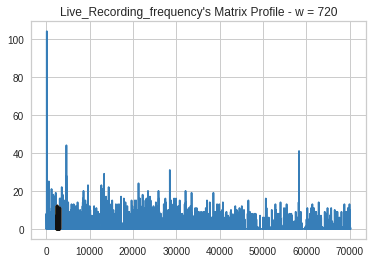

In [45]:
# plot anomalies
for label, window_size in tqdm(windows):
    studio_key = 'Studio_Recording_' + ts_column_name
    live_key = 'Live_Recording_' + ts_column_name
    
    studio_ts = df[studio_key].values
    live_ts = df[live_key].values
    
    key = '%s motifs' % str(label)
    studio_mo, studio_mod  = studio_motifs[key][0], studio_motifs[key][1]
    live_mo, live_mod = live_motifs[key][0], live_motifs[key][1]
    
    key = '%s anomalies' % str(label)
    studio_anoms  = studio_anomalies[key]
    live_anoms = live_anomalies[key]
    
    plot_anomalies(studio_ts, studio_mo, studio_anoms, window_size, studio_key)
    plot_anomalies(live_ts, live_mo, live_anoms, window_size, live_key)